# Stanley Controller for Car-Like Robots
This notebook simulates the Stanley controller for tracking a circular reference path.
It demonstrates both theory and implementation with animation.

---


## Theory

The **Stanley controller** is used for path tracking in car-like robots.
It minimizes:
- **Heading error** between the robot's orientation and path tangent
- **Cross-track error** (perpendicular distance from front axle to reference path)

### Control Law:

$
\delta = \theta_p - \theta + \arctan\left(\frac{k e}{v}\right)
$

Where:
- $ \theta $: vehicle heading  
- $ \theta_p $: path heading  
- $ e $: cross-track error  
- $ k $: control gain  
- $ v $: vehicle speed

This method is widely used in autonomous driving (e.g., in the ROS navigation stack).


## Stanley Controller: Background

This section describes the core logic behind the Stanley controller, which is a geometric method for lateral control of car-like mobile robots.

### Objective

The Stanley controller aims to reduce two types of error:
1. **Heading error**: the difference between the vehicle's heading and the tangent to the reference path at the closest point.
2. **Cross-track error**: the perpendicular distance between the vehicle’s front axle and the reference path.

The controller computes a steering angle \( \delta \) that accounts for both:

$
\delta = \alpha + \arctan\left(\frac{k \cdot e}{v}\right)
$

where:
- $ \alpha = \theta_p - \theta $: heading error (desired heading minus current heading),
- $ e $: signed cross-track error,
- $ v $: vehicle forward speed,
- $ k $: positive gain constant (Stanley gain).

The steering angle $ \delta $ is then used to update the robot’s orientation via a simple bicycle model.

---

### Reference Path

The reference trajectory is defined as a sequence of waypoints:
$
\{(x_i^{\text{ref}}, y_i^{\text{ref}})\},\quad i = 0, \dots, N
$

At each time step, the controller must:
1. Identify the closest reference point ahead of the robot (not necessarily the nearest one in Euclidean distance).
2. Compute the errors relative to that point.
3. Apply the control law.

---

### Cross-Track Error

The cross-track error $ e $ is the perpendicular distance from the vehicle’s front axle position to the reference path. It can be computed using the 2D cross product:

Let:
- $ (x, y) $: vehicle’s rear axle position,
- $ \theta $: vehicle heading,
- $ L $: wheelbase length,
- $ (f_x, f_y) = (x + L \cos(\theta), y + L \sin(\theta)) $: front axle position,
- $ (x_p, y_p) $: closest reference point,
- $ \vec{r} = [f_x - x_p, f_y - y_p] $: vector from reference to front axle,
- $ \vec{t} = [\cos(\theta_p), \sin(\theta_p)] $: unit tangent at reference point.

Then:
$
e = \vec{t} \times \vec{r}
$
which in 2D is equivalent to:
$
e = t_x r_y - t_y r_x
$

This gives a signed value: positive means the front axle is to the left of the reference path direction, and negative means it is to the right.

---

### Heading Error

The heading error $ \alpha $ is:
$
\alpha = \theta_p - \theta
$
It should be normalized to the interval $ (-\pi, \pi] $.

---

### Stanley Control Law

Combine the heading and cross-track errors using the Stanley control law:

$
\delta = \alpha + \arctan\left(\frac{k \cdot e}{v}\right)
$

A gain $ k > 0 $ determines how aggressively the robot corrects lateral error. Higher \( k \) reduces steady-state cross-track error but may introduce oscillations.

---

### Vehicle Kinematics

We use a simplified kinematic bicycle model:

$
\begin{aligned}
x_{k+1} &= x_k + v \cos(\theta_k) \Delta t \\
y_{k+1} &= y_k + v \sin(\theta_k) \Delta t \\
\theta_{k+1} &= \theta_k + \frac{v}{L} \tan(\delta_k) \Delta t
\end{aligned}
$

---

### Summary of Required Steps

1. **Find the closest reference point ahead of the vehicle** using forward projection (dot product with velocity direction).
2. **Compute the cross-track error** using the 2D cross product.
3. **Compute the heading error** and normalize it.
4. **Apply the Stanley control law** to compute the steering angle.
5. **Update the robot's state** using the kinematic model.


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from math import atan2, tan, sin, cos, sqrt, pi, nan

# Simulation parameters
dt = 0.1            # time step
total_time = 150.0
k = 2.0       # Stanley gain
L = 1.0             # Wheelbase
v = 1.0        # Constant velocity


In [95]:
# Circular reference circular trajectory

# parameters for circular trajectory

t_radius = 5.0

t_vals = np.linspace(0, 2 * np.pi, int(total_time / dt))# use np.linspace to generate waypoints
ref_x = t_radius * np.cos(t_vals) # Complete
ref_y = t_radius * np.sin(t_vals) # Complete
ref_yaw = np.arctan2(np.gradient(ref_y), np.gradient(ref_x)) # Because tangents to a circle are at +90° to the radius # Complete

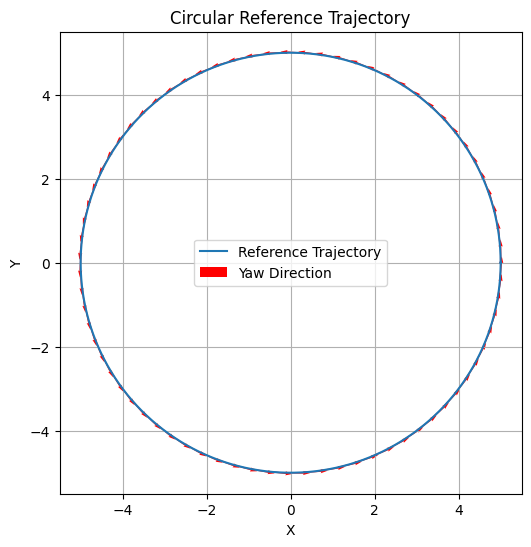

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the trajectory
plt.figure(figsize=(6,6))
plt.plot(ref_x, ref_y, label="Reference Trajectory")
plt.quiver(ref_x[::20], ref_y[::20],  # plot arrows every 20 points
           np.cos(ref_yaw[::20]), np.sin(ref_yaw[::20]),
           color='r', scale=20, width=0.003, label='Yaw Direction')

plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Circular Reference Trajectory")
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# Initial conditions
x = 0
y = -5.0
yaw = pi

x_history = [x]
y_history = [y]
yaw_history = [yaw]


In [86]:
def wrap_angle(angle):
    while angle > pi:
        angle -= 2.0 * pi
    while angle < -pi:
        angle += 2.0 * pi
    return angle

In [98]:
# TODO: Implement Stanley controller loop

for _ in range(len(t_vals)):
    # TODO: Find the closest point ahead of the robot
    # Use forward projection condition: dot product > 0
    # idx = ...

    min_dist = float('inf')
    idx = 0

    fx = x + L * cos(yaw)
    fy = y + L * sin(yaw)

    for i in range(len(ref_x)):
        dx = fx - ref_x[i]
        dy = fy - ref_y[i]
        dist = sqrt(dx ** 2 + dy **2)

        forward_proj = dx * cos(yaw) + dy * sin(yaw)

        if dist < min_dist and forward_proj > 0:
            min_dist = dist
            idx = i
            
    # TODO: Compute cross-track error
    # dx = ...
    # dy = ...
    # fx = ...
    # fy = ...
    # ref_vec = ...
    # cross_track_error = ...

    dx = fx - ref_x[idx]
    dy = fy - ref_y[idx]
    ref_vec = np.array([cos(ref_yaw[idx]), sin(ref_yaw[idx])])
    cross_track_error = ref_vec[0] * dy - ref_vec[1] * dx

    # TODO: Compute heading error
    # heading_error = ...
    heading_error = wrap_angle(ref_yaw[idx] - yaw)

    # TODO: Stanley control law
    # delta = ...
    delta = heading_error + atan2(k * cross_track_error, v)

    # TODO: Motion model
    # x += ...
    # y += ...
    # yaw += ...
    # yaw = normalize_angle(yaw)
    x += v * cos(yaw) * dt
    y += v * sin(yaw) * dt
    yaw += v/L * tan(delta) * dt
    yaw = wrap_angle(yaw)

    x_history.append(x)
    y_history.append(y)
    yaw_history.append(yaw)


Text(0.5, 1.0, 'Tracking error over time')

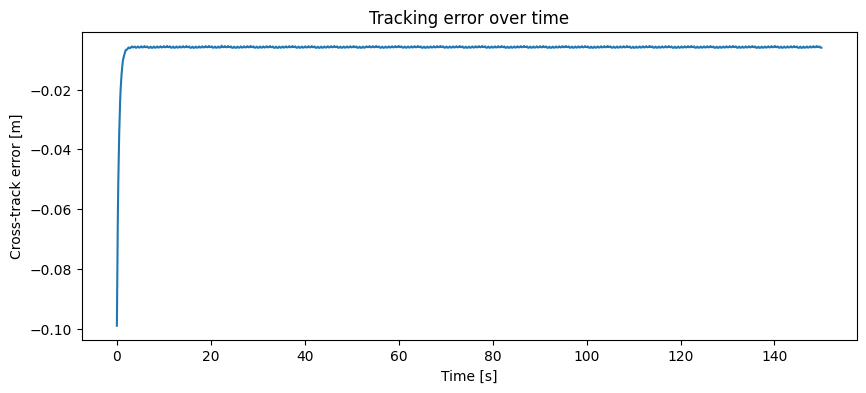

In [99]:
# Error plotting
cross_track_errors = []

for i in range(len(x_history)):
    x = x_history[i]
    y = y_history[i]
    yaw = yaw_history[i]

    fx = x + L * cos(yaw)
    fy = y + L * sin(yaw)

    # Find closest point
    min_dist = float('inf')
    idx = 0
    
    for j in range(len(ref_x)):
        dx = ref_x[j] - fx
        dy = ref_y[j] - fy
        dist = sqrt(dx ** 2 + dy **2)

        forward_proj = dx * cos(yaw) + dy * sin(yaw)

        if dist < min_dist and forward_proj > 0:
            min_dist = dist
            idx = j

    dx = fx - ref_x[idx]
    dy = fy - ref_y[idx]
    ref_vec = np.array([cos(ref_yaw[idx]), sin(ref_yaw[idx])])
    cross_track_error = ref_vec[0] * dy - ref_vec[1] * dx

    cross_track_errors.append(cross_track_error)

# Error plot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(cross_track_errors)) * dt, cross_track_errors, label="Cross-track error e(t)")
plt.xlabel("Time [s]")
plt.ylabel("Cross-track error [m]")
plt.title("Tracking error over time")


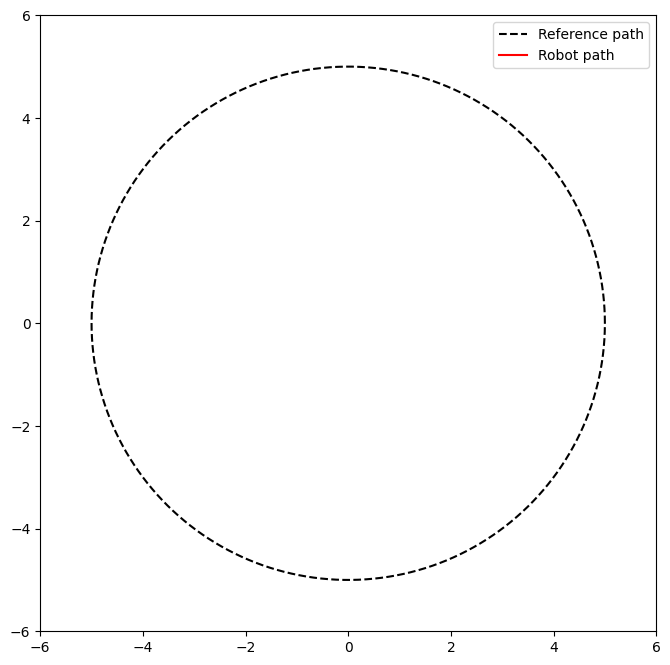

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ref_x, ref_y, 'k--', label="Reference path")
robot_path, = ax.plot([], [], 'r-', label="Robot path")
robot_dot, = ax.plot([], [], 'ro')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_aspect('equal')
ax.legend()

def update(frame):
    if frame < 2:
        robot_path.set_data([], [])
        robot_dot.set_data([], [])
    else:
        robot_path.set_data(x_history[:frame], y_history[:frame])
        robot_dot.set_data([x_history[frame]], [y_history[frame]])
    return robot_path, robot_dot

anim = animation.FuncAnimation(fig, update, frames=len(x_history), interval=50)
HTML(anim.to_html5_video())
